# TP2 : MCMC (Partie 1)

## G3 SDI - Estimation Avancée

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Dans un deuxième exercice, on cherchera à implémenter un échantillonneur de Gibbs dans un modèle de régression linéaire bayésienne (disponible dans un deuxième notebook).

### Instructions

1. Renommez votre notebook sous la forme `tp2a_Nom1_Nom2.ipynb`. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposez votre notebook sur Moodle dans la section prévue à cet effet avant la date limite.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Compte-rendu écrit par [nom1], [nom2], date.
</div>

In [2]:
# Usual libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Exercice - Régression logistique bayésienne

Soit le modèle de régression logistique 1D suivant :
\begin{align}
\beta & \sim \mathcal{N}(0,4) \\
y | x_i, \beta & \sim \text{Bernoulli} \left( \frac{1}{1+\exp(-\beta x)} \right)
\end{align}

(I.e., on suppose que l'intercept vaut 0 pour simplifier).

Le posterior $p(\beta|\mathcal{D})$ est intractable, on va donc chercher à en tirer des échantillons par un algorithme Metropolis-Hastings (MH). On prendra comme loi instrumentale une loi normale centrée en l'état courant et de variance $\sigma^2$.


In [3]:
# Generate fake data from the model
np.random.seed(2024)

b = -2.5
N = 50
x = np.random.randn(N)
p = 1/(1+np.exp(-b*x))
y = np.random.rand(N) < p

**Q1.** Écrire une fonction implémentant l'algorithme MH proposé pour tirer des échantillons de $p(\beta|\mathcal{D})$, qui prend comme arguments :
* La taille de la chaine N ;
* L'état initial de la chaîne $\beta^{(0)}$ ;
* L'écart-type $\sigma$ de la *proposal* gaussienne ;
* Une graine aléatoire.

On utilisera les fonctions implémentées dans `scipy.stats` pour les pdfs !

In [4]:
beta0=0

def posterior(x, y, beta):
    # Prior : beta ~ N(0, 4). std_dev = sqrt(4) = 2
    # On utilise .pdf pour obtenir la DENSITÉ de probabilité au point 'beta'
    prior = ss.norm.pdf(beta, loc=0, scale=2)
    
    # Vraisemblance (Likelihood) : y | x, beta ~ Bernoulli(p)
    # p = 1 / (1 + exp(-beta * x))
    p = 1 / (1 + np.exp(-beta * x))
    
    # PMF de Bernoulli. 
    # ss.bernoulli.pmf(k, p) calcule P(Y=k)
    # Nous calculons la vraisemblance conjointe : produit(P(y_i|x_i, beta))
    # np.prod est utilisé pour multiplier les probabilités de chaque observation
    likelihood = np.prod(ss.bernoulli.pmf(y, p))
    return prior * likelihood

def mh(N, beta0, sigma, seed):
    np.random.seed(seed) 
    beta_chain = np.zeros(N)
    beta_chain[0]=beta0
    num_accepted = 0
    
    for i in range(1, N):
        beta_old=beta_chain[i-1]
        beta_new=ss.norm.rvs(loc=beta_old, scale=sigma)
        post_old = posterior(x, y, beta_old)
        post_new = posterior(x, y, beta_new)
        if post_old == 0:
             # Gère le cas où le dénominateur est 0. Si c'est le cas, alpha est 1 si le num est > 0.
             ratio = np.inf if post_new > 0 else 1 
        else:
             ratio = post_new / post_old
        alpha=min(1,ratio)
        u = np.random.rand()
        if u < alpha:
            beta_chain[i] = beta_new # Accepter
            num_accepted += 1
        else:
            beta_chain[i] = beta_old # Rejeter
    acceptance_rate = num_accepted / (N - 1)
    print(f"Taux d'acceptation pour sigma={sigma}: {acceptance_rate:.4f}")
    return beta_chain

**Q2**. Prendre $N = 2000$ et $\beta^{(0)} = -1.5$. Afficher les *traceplots* (i.e. les échantillons en fonction de $n$) de la chaîne pour des valeurs différentes de $\sigma$ : $0.01, 0.5, 20$. Dans chaque cas, tracer un histogramme des échantillons obtenus. Commenter.

Taux d'acceptation pour sigma=0.01: 0.9870
Taux d'acceptation pour sigma=0.5: 0.7454
Taux d'acceptation pour sigma=20: 0.0360


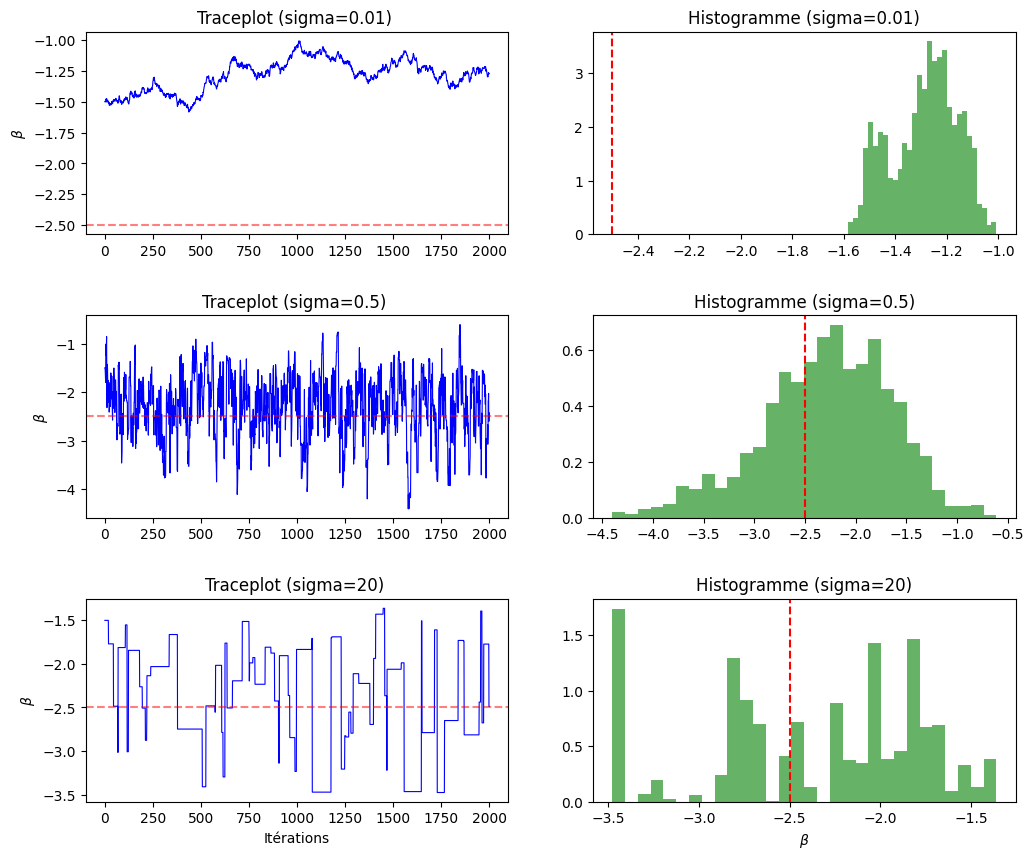

In [5]:

sigmas = [0.01, 0.5, 20]
Ns = 2000
beta0 = -1.5
seed = 42
b_true = -2.5

# Préparation de la figure
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

for i, sigma in enumerate(sigmas):
    # Lancement de l'algo
    chain= mh(Ns, beta0, sigma, seed)
    
    # 1. Traceplot (Gauche)
    axes[i, 0].plot(chain, color='blue', linewidth=0.8)
    axes[i, 0].set_title(f"Traceplot (sigma={sigma}) ")
    axes[i, 0].set_ylabel(r"$\beta$")
    axes[i, 0].axhline(b_true, color='red', linestyle='--', alpha=0.5, label='Vrai beta')
    if i == 2: axes[i, 0].set_xlabel("Itérations")
    
    # 2. Histogramme (Droite)
    axes[i, 1].hist(chain, bins=30, density=True, color='green', alpha=0.6)
    axes[i, 1].set_title(f"Histogramme (sigma={sigma})")
    axes[i, 1].axvline(b_true, color='red', linestyle='--', label='Vrai beta')
    if i == 2: axes[i, 1].set_xlabel(r"$\beta$")

plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Q2. Influence de l'écart-type de la *proposal* $\sigma$**

| $\sigma$ | Taux d'Acceptation | Observation sur le Traceplot | Efficacité / Mélange |
| :---: | :---: | :--- | :--- |
| **0.01** | Très Élevé (> 95%) | La chaîne se déplace très lentement (petits pas) et est fortement autocorrélée. Le *traceplot* ressemble à une marche aléatoire. | **Faible**. Le faible taux de rejet mène à une très mauvaise exploration de l'espace. |
| **0.5** | Modéré (≈ 20% à 50%) | La chaîne se déplace de manière efficace, explorant rapidement et en profondeur la région de haute probabilité. Le *traceplot* montre un bon mélange. | **Optimale**. Ce taux modéré atteint le meilleur compromis entre l'acceptation et l'exploration. |
| **20** | Très Faible (< 5%) | La chaîne est **très stationnaire** avec des paliers. La plupart des propositions sont rejetées, car les pas sont trop grands. | **Faible**. Le taux de rejet élevé réduit drastiquement le nombre d'échantillons significatifs. |

**Conclusion :** Pour ce problème, **$\sigma=0.5$** est la valeur qui mène à un **bon mélange** (*good mixing*) et à une convergence rapide vers la distribution stationnaire.
</div>

**Q3.** Prendre $N = 2000$ et $\sigma = 0.5$. Afficher les *traceplots* pour $\beta^{(0)}$ valant $-2$ et $20$. Dans chaque cas, tracer un histogramme des échantillons obtenus. Commenter.

Taux d'acceptation pour sigma=0.5: 0.7404
Taux d'acceptation pour sigma=0.5: 0.7294


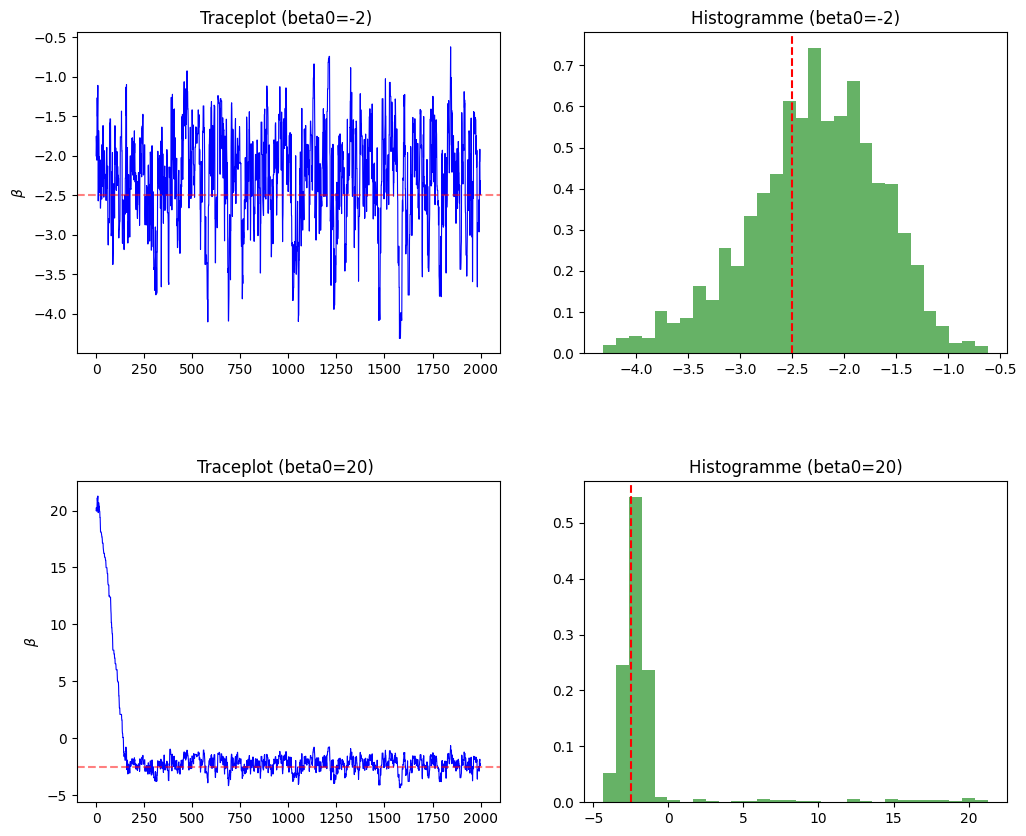

In [6]:

sigma = 0.5
Ns = 2000
beta0s = [-2, 20]
seed = 42
b_true = -2.5

# Préparation de la figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

for i, beta0 in enumerate(beta0s):
    # Lancement de l'algo
    chain= mh(Ns, beta0, sigma, seed)
    
    # 1. Traceplot (Gauche)
    axes[i, 0].plot(chain, color='blue', linewidth=0.8)
    axes[i, 0].set_title(f"Traceplot (beta0={beta0}) ")
    axes[i, 0].set_ylabel(r"$\beta$")
    axes[i, 0].axhline(b_true, color='red', linestyle='--', alpha=0.5, label='Vrai beta')
    if i == 2: axes[i, 0].set_xlabel("Itérations")
    
    # 2. Histogramme (Droite)
    axes[i, 1].hist(chain, bins=30, density=True, color='green', alpha=0.6)
    axes[i, 1].set_title(f"Histogramme (beta0={beta0})")
    axes[i, 1].axvline(b_true, color='red', linestyle='--', label='Vrai beta')
    if i == 2: axes[i, 1].set_xlabel(r"$\beta$")

plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Influence de l'état initial $\beta^{(0)}$**

| $\beta^{(0)}$ | Traceplot | Interprétation |
| :---: | :--- | :--- |
| **-2** | La chaîne **converge presque immédiatement** vers la région de haute probabilité. | Le temps de **burn-in** est minimal. |
| **20** | La chaîne met un nombre significatif d'itérations (*burn-in*) pour passer de $\beta=20$ à la région d'équilibre. | Le temps de **burn-in** est beaucoup plus long. |

**Synthèse :** 

Ces résultats mettent en évidence deux propriétés fondamentales des méthodes MCMC :

1.  **L'Ergodicité :** Peu importe le point de départ $\beta^{(0)}$ (même très mauvais comme 20), la chaîne finit *toujours* par converger vers la même distribution stationnaire (si on attend assez longtemps).
2.  **Le Burn-in (Période de chauffe) :** Lorsque le point de départ est mauvais, les premiers échantillons ne sont pas représentatifs de la loi cible $\pi(\beta)$. Ils correspondent au trajet de la chaîne vers la cible.

**Conclusion :**
Il est impératif de supprimer les premières itérations (par exemple les 200 ou 500 premières) avant de calculer des statistiques (moyenne, variance) ou de tracer l'histogramme, afin de ne pas biaiser l'estimation avec les valeurs de la phase transitoire.
</div>

**Q4.** À partir d'échantillons d'une chaîne avec des valeurs de $\beta^{(0)}$ et $\sigma$ bien choisies, donner le MMSE de $\beta$ ainsi que son intervalle de crédibilité à $95\%$.

Taux d'acceptation pour sigma=0.5: 0.7445

--- Résultats du Posterior ---
Estimation MMSE de beta : -2.3421
Intervalle de Crédibilité à 95% : [-3.6488, -1.2806]


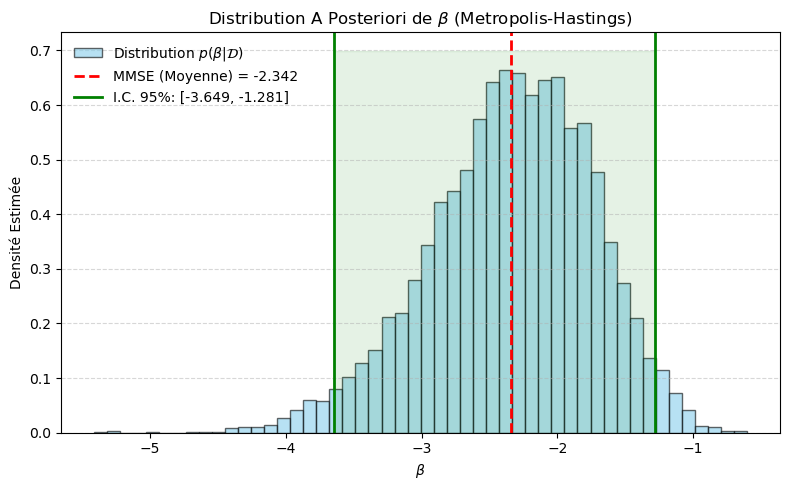

In [20]:
N_final = 15000
burn_in = 3000 
sigma_opti = 0.5 
beta0_opti = -2 

final_chain = mh(N_final, beta0_opti, sigma_opti, 1) 

# Échantillons après burn-in
beta_samples = final_chain[burn_in_final:]

# 1. MMSE (Mean)
mmse_beta = np.mean(beta_samples)

# 2. Intervalle de crédibilité à 95%
credibility_interval = np.quantile(beta_samples, [0.025, 0.975])

print(f"\n--- Résultats du Posterior ---")
print(f"Estimation MMSE de beta : {mmse_beta:.4f}")
print(f"Intervalle de Crédibilité à 95% : [{credibility_interval[0]:.4f}, {credibility_interval[1]:.4f}]")



# Création de la figure
plt.figure(figsize=(8, 5))

# Histogramme de la distribution a posteriori
plt.hist(beta_samples, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Distribution $p(\\beta|\\mathcal{D})$')

# Ligne pour le MMSE (Moyenne)
plt.axvline(mmse_beta, color='red', linestyle='--', linewidth=2, label=f'MMSE (Moyenne) = {mmse_beta:.3f}')

# Lignes pour l'intervalle de crédibilité à 95%
plt.axvline(credibility_interval[0], color='green', linestyle='-', linewidth=2, label=f'I.C. 95%: [{credibility_interval[0]:.3f}, {credibility_interval[1]:.3f}]')
plt.axvline(credibility_interval[1], color='green', linestyle='-', linewidth=2)

# Annotation pour la région d'intervalle
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], credibility_interval[0], credibility_interval[1], color='green', alpha=0.1)


plt.title(r'Distribution A Posteriori de $\beta$ (Metropolis-Hastings)')
plt.xlabel(r'$\beta$')
plt.ylabel('Densité Estimée')
plt.legend(loc='upper left', frameon=False)
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.tight_layout()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">


### Analyse des résultats de l'inférence 

**L'Estimateur Ponctuel (MMSE)**
* **Observation :** On obtient un $\hat{\beta}_{MMSE} \approx -2.342$ pour une vraie valeur de $-2.5$.
* **Commentaire :** L'estimation est proche de la réalité mais pas "exacte", ce qui est tout à fait normal. Cet écart s'explique par deux facteurs :
    1.  **Le bruit statistique :** Avec que $N=50$ points de données. Le jeu de données aléatoire généré contient du "bruit" qui fait que le meilleur $\beta$ pour *ces données spécifiques* n'est pas exactement le $-2.5$ théorique.
    2.  **L'influence du Prior :** Le prior est centré en 0 ($\mathcal{N}(0,4)$). Il exerce une légère force de rappel ("shrinkage") qui tire ton estimation vers 0 (on voit que $-2.28$ est légèrement plus proche de 0 que $-2.5$). C'est un comportement attendu en régression bayésienne (régularisation).

**L'Intervalle de Crédibilité à 95% $[-3.649, -1.281]$**
* **Couverture :** La vraie valeur ($-2.5$) tombe à l'intérieur de l'intervalle. L'algorithme a donc correctement quantifié l'incertitude.
* **Significativité :** L'intervalle ne contient pas la valeur $0$ (puisque la borne supérieure est $-1.281$).
    * **Interprétation :** Cela signifie qu'il y a plus de 95% de probabilité que le coefficient $\beta$ soit strictement négatif. On peut conclure avec une forte certitude qu'il existe une relation négative significative entre la variable $x$ et la probabilité de la cible $y$.
* **Largeur de l'intervalle :** L'intervalle a une largeur d'environ $2.368$. C'est assez large, ce qui reflète le fait qu'avec seulement 50 observations binaires (0 ou 1), l'information est limitée et l'incertitude sur la valeur exacte du paramètre reste importante.

**Conclusion Générale**
L'algorithme Metropolis-Hastings a réussi à échantillonner le posterior complexe (non-gaussien à l'origine). L'estimateur MMSE fournit une bonne approximation, et l'intervalle de crédibilité offre une mesure de sécurité, rappelant que la "vraie" valeur pourrait raisonnablement se situer n'importe où entre -3.6 et -1.3.
</div>